# Tutorial part 3

In [part 1](part1.ipynb) and [part 2](part2.ipynb) we have learnt about portfolio lines. These are timeseries, or collections of timeseries, describing the volumes and/or prices during various delivery periods.

In this part, we'll combine portfolio lines into a "portfolio state" (``PfState``) object. As we'll see, some of the methods and properties we know from the ``PfLine`` class also apply here.


## Example data

Let's again use the mock functions to get some portfolio lines. (The parameter details here are not important, we just want some more-or-less realistic data). To change things up a bit from the previous tutorial parts, we'll look at about 80 days in the autumn of 2024, in quarterhourly (``"15T"``) resolution. And let's localize the data to a specific timezone:

In [21]:
import portfolyo as pf
import pandas as pd

index = pd.date_range(
    "2024-09-20", "2024-12-10", freq="15T", inclusive="left", tz="Europe/Berlin"
)
# Creating offtake portfolio line.
ts_offtake = -1 * pf.dev.w_offtake(index, avg=50)
offtake = pf.PfLine({"w": ts_offtake})
# Creating portfolio line with market prices (here: forward price curve).
ts_prices = pf.dev.p_marketprices(index, avg=200)
prices = pf.PfLine({"p": ts_prices})

# Creating portfolio line with sourced volume.
ts_sourced_power1, ts_sourced_price1 = pf.dev.wp_sourced(
    ts_offtake, "QS", 0.3, p_avg=120
)
sourced_quarters = pf.PfLine({"w": ts_sourced_power1, "p": ts_sourced_price1})
ts_sourced_power2, ts_sourced_price2 = pf.dev.wp_sourced(
    ts_offtake, "MS", 0.2, p_avg=150
)
sourced_months = pf.PfLine({"w": ts_sourced_power2, "p": ts_sourced_price2})
sourced = pf.MultiPfLine(
    {"quarter_products": sourced_quarters, "month_products": sourced_months}
)

We can now use these portfolio lines to create a portfolio state. 

### One more thing about portfolio lines

As we now have portfolio lines with a resolution of 1 hour or less, we can decompose the data in peak and offpeak values with the ``.po()`` method:

In [22]:
prices.po("MS")

c:\users\ruud.wijtvliet\ruud\python\dev\portfolyo\portfolyo\tools\stamps.py:404: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq = ts_left.freq
c:\Users\ruud.wijtvliet\Anaconda3\envs\pf38\lib\site-packages\pint_pandas\pint_array.py:194: RuntimeWarning: pint-pandas does not support magnitudes of <class 'int'>. Converting magnitudes to float.
  warnings.warn(


peak                      offpeak  \
                          duration                   p duration   
2024-10-01 00:00:00+02:00    276.0  259.45559217802946    469.0   
2024-11-01 00:00:00+01:00    252.0  287.19335444058794    468.0   

                                               
                                            p  
2024-10-01 00:00:00+02:00  156.73342770442454  
2024-11-01 00:00:00+01:00   183.9340378147048

This simply splits the timestamps into peak and offpeak groups (in this case, per month) and calculates the aggregates in each group.

## Portfolio State

The ``PfState`` class is used to hold information about offtake, market prices, and sourcing. Let's create one from the portfolio lines we just created:

In [23]:
pfs = pf.PfState(offtake, prices, sourced)

This portfolio state contains values for every quarterhour in the specified time period. Let's see what features this class has, starting with two methods we already met when discussing the ``PfLine`` class.

### Plotting

Just as when working with portfolio lines, we can get a quick overview of the portfolio state with the ``.plot()`` method:

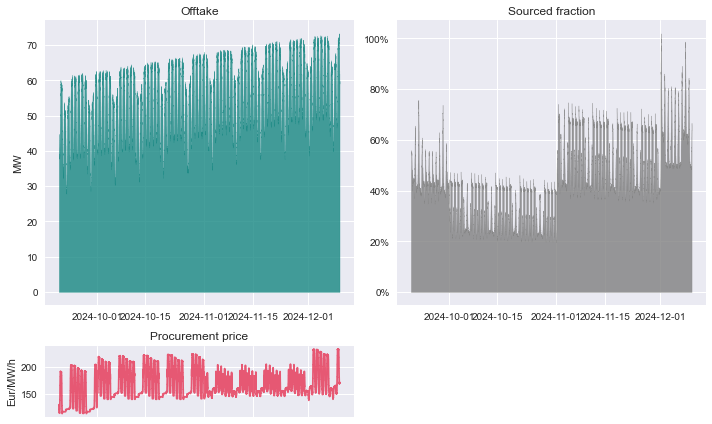

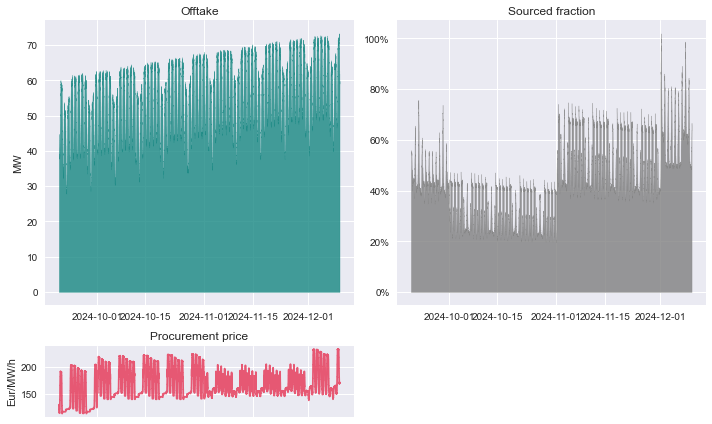

In [24]:
pfs.plot()

Looking at the offtake, we can see the daily and weekly cycles, as well as a slow increase over the entire time period.

This graph is a bit too detailed for most purposes, so let's look at the second method we know from ``PfLine``: resampling.

### Resampling

We might prefer to see hourly, daily, or monthly values instead of the quarterhourly values that are in ``pfs``. For this, we can resample the object with the ``.asfreq()`` method. In this code example, we also use the ``.print()`` method, which adds some helpful coloring to the output:

In [25]:
pfs_monthly = pfs.asfreq("MS")
pfs_monthly.print()

PfState object.
. Timestamps: first: 2024-10-01 00:00:00+02:00     timezone: Europe/Berlin
               last: 2024-11-01 00:00:00+01:00         freq: <MonthBegin> (2 datapoints)
                                                w           q           p             r
                                               MW         MWh     Eur/MWh           Eur
──────── offtake
           2024-10-01 00:00:00 +0200        -54.7     -40 744                          
           2024-11-01 00:00:00 +0100        -59.4     -42 734                          
─●────── pnl_cost
 │         2024-10-01 00:00:00 +0200         54.7      40 744      176.57     7 193 938
 │         2024-11-01 00:00:00 +0100         59.4      42 734      166.74     7 125 316
 ├●───── sourced
 ││        2024-10-01 00:00:00 +0200         17.9      13 346      136.84     1 826 334
 ││        2024-11-01 00:00:00 +0100         32.0      23 067      125.13     2 886 272
 │├───── quarter_products
 ││        2024-10-01 00:00:00 +0200  

Note how the resampled output only contains those months, that are *entirely* included in the original data. ``pfl`` has data in September and December, but as these are not present in their entirety, they are dropped from ``pfl_monthly``.

Let's look at this portfolio state in a bit more detail, to learn about the ``PfState`` class.

### Components

The portfolio state is presented to us as a tree structure, with several branches. Each branch is a portfolio line. E.g, ``offtake`` and ``sourced`` are the portfolio lines we specified when creating the object. Also, the brance ``pnl_cost`` is the sum of ``sourced`` and ``unsourced``, with ``sourced`` being the sum of ``quarter_products`` and ``month_products``. 

The unsourced volume is found by comparing the offtake to what is already sourced. This volume is valued at the market prices in the forward curve.

These portfolio lines can be obtained from the portfolio state by accessing them as attributes. E.g. ``.offtake``, ``.sourced``, ``.unsourced``, or ``.pnl_cost``. The latter is the best estimate for what it will cost to procure the offtake:

In [26]:
pfs_monthly.pnl_cost

PfLine object with price and volume information.
. Timestamps: first: 2024-10-01 00:00:00+02:00     timezone: Europe/Berlin
               last: 2024-11-01 00:00:00+01:00         freq: <MonthBegin> (2 datapoints)
. Children: 'sourced' (price and volume), 'unsourced' (price and volume)

                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-10-01 00:00:00 +0200         54.7      40 744      176.57     7 193 938
2024-11-01 00:00:00 +0100         59.4      42 734      166.74     7 125 316

Notice that this portfolio line has children, and as a reminder, we can "drill into" the object to get these nested portfolio line, e.g. with ``pfl_monthly.pnl_cost["sourced"]``.

There are some other components that are not explicitly shown. 

* We may be interested in how much of the offtake has already been sourced or unsourced. These fractions are available at the ``.sourcedfraction`` and ``.unsourcedfraction`` properties.

* You may have noticed that ``unsourced`` is the inverse from what traders would call the "open positions" or "portfolio positions": if our portfolio is short, the unsourced volume is positive. For those that prefer this other perspective, it is available at ``.netposition``.

### Export

Just as with portfolio lines, we can create an excel file that contains all the information in a portfolio state with its ``.to_excel()`` method, and we can copy it to the clipboard with the ``.to_clipboard()`` method.

### MtM

We can evaluate the value of our sourcing contracts against the current forward curve ("mark-to-market") with the ``.mtm_of_sourced()`` method.

## Sign conventions

The following conventions are used:

* Volume that leaves the portfolio (e.g. due to offtake) is negative, volume that enters it (e.g. due to sourcing) is positive. 

  - Offtake should therefore be negative;
  - Sourcing should be positive in the aggregate, though individual sourcing components can be negative, e.g. when selling long volumes on the spot market.  
  - In graphs, offtake and sourcing are often plotted on the same graph, or side-by-side. In that case the offtake is presented with positive values to facilitate the comparison.

* Prices are positive when the buyer of good pays money to the seller. This is the case in all but the most extreme market situations (e.g. on the spot market).

* The result of the conventions above is that money that enters the portfolio is negative, and money that leaves it is positive. In general: monetary values can be seen as "costs", with negative values being income.

## Arithmatic with portfolio states

.... #TODO

## Analyses with portfolio states

We'll now look at how we can do what-if analyses with portfolio state. The original portfolio state we will consider as the reference and store it in an appropriately named variable:

In [27]:
ref = pfs

The monthly procurement prices of this portfolio are what interest us the most. As a reminder, we can find the procurement volumes and costs with:

In [28]:
cost_ref = ref.asfreq("MS").pnl_cost
cost_ref

PfLine object with price and volume information.
. Timestamps: first: 2024-10-01 00:00:00+02:00     timezone: Europe/Berlin
               last: 2024-11-01 00:00:00+01:00         freq: <MonthBegin> (2 datapoints)
. Children: 'sourced' (price and volume), 'unsourced' (price and volume)

                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-10-01 00:00:00 +0200         54.7      40 744      176.57     7 193 938
2024-11-01 00:00:00 +0100         59.4      42 734      166.74     7 125 316

(Or we could go one step further and focus on only the prices with ``ref.asfreq("MS").pnl_cost.p``.)

### Change in offtake

Now, what would happen if the offtake were to increase by 25%? Qualitatively, this is not hard. An increase in the offtake increases the unsourced volume. And because the market prices are higher than what we pay for the sourced volume, this means that the procurement price will go up. 

How much? Let's see. First, we create a new portfolio state, from the reference, by setting the offtake to the new value. We can do this with the ``.set_offtake()`` method. After that, we can again see what the procurement volumes and costs are:

In [29]:
higherofftake = ref.offtake * 1.25
pfs_higherofftake = ref.set_offtakevolume(higherofftake)
cost_higherofftake = pfs_higherofftake.asfreq("MS").pnl_cost
cost_higherofftake

c:\users\ruud.wijtvliet\ruud\python\dev\portfolyo\portfolyo\core\pfstate\pfstate.py:186: UserWarning: This changes the unsourced volume and causes inaccuracies in its price, if the portfolio has a frequency that is longer than the spot market.
  warnings.warn(


PfLine object with price and volume information.
. Timestamps: first: 2024-10-01 00:00:00+02:00     timezone: Europe/Berlin
               last: 2024-11-01 00:00:00+01:00         freq: <MonthBegin> (2 datapoints)
. Children: 'sourced' (price and volume), 'unsourced' (price and volume)

                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-10-01 00:00:00 +0200         68.4      50 930      181.51     9 244 336
2024-11-01 00:00:00 +0100         74.2      53 417      178.58     9 539 026

Comparing these two ``cost`` portfolio lines, we see that indeed the values for ``w`` and ``q`` have increased to 125% of the original values. Also, the procurement prices have increased. We can quickly calculate by how much:

In [19]:
cost_higherofftake.p - cost_ref.p

2024-10-01 00:00:00+02:00    10.45913775625425
2024-11-01 00:00:00+01:00    7.684585157828025
Freq: MS, Name: p, dtype: pint[Eur/MWh]

### Change in market prices

What would happen, when the market prices drop by 40%? This is very similar:

In [20]:
lowerprices = ref.unsourcedprice * 0.6
pfs_lowerprices = ref.set_unsourcedprice(lowerprices)
cost_lowerprices = pfs_lowerprices.asfreq("MS").pnl_cost
cost_lowerprices

PfLine object with price and volume information.
. Timestamps: first: 2024-10-01 00:00:00+02:00     timezone: Europe/Berlin
               last: 2024-11-01 00:00:00+01:00         freq: <MonthBegin> (2 datapoints)
. Children: 'sourced' (price and volume), 'unsourced' (price and volume)

                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-10-01 00:00:00 +0200         54.7      40 753      118.85     4 843 613
2024-11-01 00:00:00 +0100         59.3      42 719      140.22     5 990 077

As part of the volume is unsourced, this price drop makes it cheaper, causing a drop also in the total procurement price.

Of course, we can combine these two effects, e.g. with:

In [30]:
pfs_lowerprices_higherofftake = ref.set_offtakevolume(higherofftake).set_unsourcedprice(
    lowerprices
)

c:\users\ruud.wijtvliet\ruud\python\dev\portfolyo\portfolyo\core\pfstate\pfstate.py:186: UserWarning: This changes the unsourced volume and causes inaccuracies in its price, if the portfolio has a frequency that is longer than the spot market.
  warnings.warn(


We won't here do the calculations to see the effect on the procurement prices.


This tutorial is continued [in part 4](part4.ipynb).